In [1]:
import keras
print('keras: %s' % keras.__version__)

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


keras: 2.1.6


In [2]:
import datetime
import pickle
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.simplefilter("ignore")

In [3]:
# Load data
data = pd.read_csv('AMZN.csv')

### Data Exploration

In [4]:
data.shape

(1258, 7)

In [5]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-12-09,388.109985,388.209991,382.570007,384.890015,384.890015,2761800
1,2013-12-10,383.739990,389.059998,383.019989,387.779999,387.779999,2736800
2,2013-12-11,387.339996,388.980011,382.000000,382.190002,382.190002,2451300
3,2013-12-12,381.260010,385.000000,379.500000,381.250000,381.250000,2123700
4,2013-12-13,385.320007,389.420013,383.799988,384.239990,384.239990,3025000


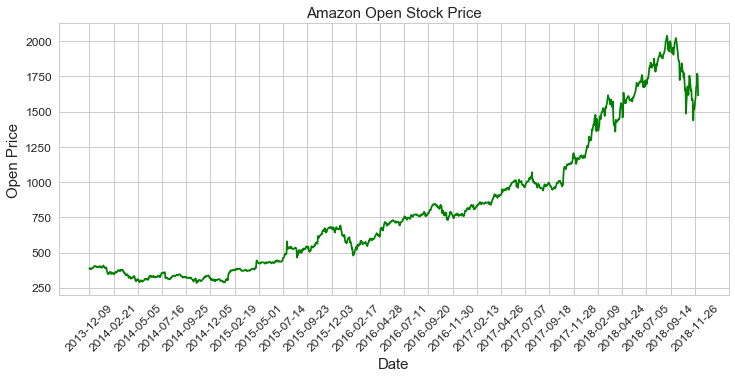

In [6]:
sns.set(style = 'whitegrid')
plt.figure(figsize = (12,5))
plt.plot(range(data.shape[0]),data['Open'],'g')
plt.xticks(range(0,data.shape[0],50),data['Date'].loc[::50],rotation=45,fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Amazon Open Stock Price',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Open Price',fontsize=15)
plt.show()

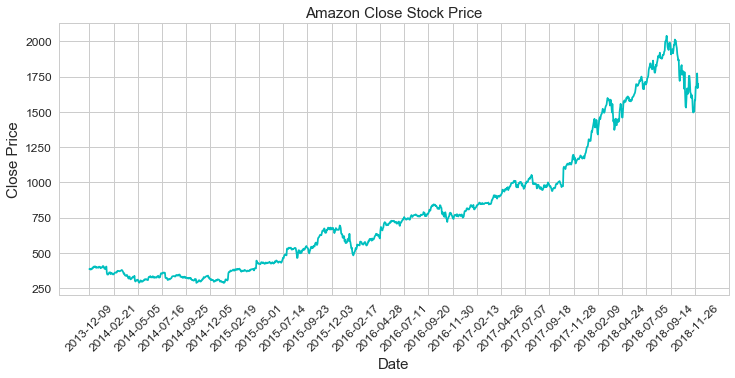

In [7]:
sns.set(style = 'whitegrid')
plt.figure(figsize = (12,5))
plt.plot(range(data.shape[0]),data['Close'],'c')
plt.xticks(range(0,data.shape[0],50),data['Date'].loc[::50],rotation=45,fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Amazon Close Stock Price',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Close Price',fontsize=15)
plt.show()

The above two graphs show different behaviors of open and close stock prices over time. Both stock prices are almost close to each other. Another thing to notice is that the values close to 2018 are much higher and fluctuate more than the values close to the 2013. Therefore, we need to make sure that the data behaves in similar value ranges throughout the time frame. Due to this, data has to be normalized.

### Splitting Data into a Training set and a Test set

This dataset has 1258 data points. I will split the data into 80% training data and 20% test data.

In [8]:
0.8*data.shape[0]

1006.4000000000001

The training data will be the first 1006 data points of the time series and rest will be test data.

In [9]:
train_data = data[:1006]
test_data = data[1006:]

In [10]:
print("Shape of train data: ",train_data.shape)
print("Shape of test data: ",test_data.shape)

Shape of train data:  (1006, 7)
Shape of test data:  (252, 7)


### Data Normalization

Now we need to define a scaler to normalize the data. MinMaxScalar scales all the data to be in the range of 0 and 1. I will be considering Close price of the dataset.

In [11]:
# Close column of the dataset
training_set = train_data.iloc[:,[0,4]].values

In [12]:
training_set = pd.DataFrame(training_set)

In [13]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set[1].reshape(-1, 1))

In [14]:
# Creating a data structure with 60 timestamps and 1 output
X_train = []
y_train = []
for i in range(60,train_data.shape[0]):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [15]:
# Reshaping
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

In [16]:
X_train.shape

(946, 60, 1)

### Training Recurrent Neural Network (RNN) using LSTM

Long Short-Term memory is one of the most successful RNNs architectures. LSTM introduces the memory cell, a unit of computation that replaces traditional artificial neurons in the hidden layer of the network. With these memory cells, networks are able to effectively associate memories and input remote in time, hence suit to grasp the structure of data dynamically over time with high prediction capacity.

In [17]:
model = Sequential()

# Add first LSTM layer
model.add(LSTM(units=50, return_sequences = True, input_shape = (X_train.shape[1],1)))
model.add(Dropout(0.2))

# Add second LSTM layer
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))

# Add third LSTM layer
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))

# Add fourth LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(units = 1))

# Compile the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [68]:
# Callbacks to save best model and stop training if loss no longer decreases after 40 epochs
early_stop = EarlyStopping(monitor = 'loss', patience = 40)

checkpoint = ModelCheckpoint('Stock_Price_model.h5', monitor = 'val_loss', verbose = 1, save_best_only = True)

In [69]:
starttime1 = datetime.datetime.now()

# Fitting the RNN to the Training Set
history = model.fit(X_train, y_train, epochs = 200, batch_size = 32, validation_split = 0.1, callbacks = [checkpoint, early_stop])

endtime1 = datetime.datetime.now()

print('Train and Val time:\t ', endtime1-starttime1)

Train on 851 samples, validate on 95 samples
Epoch 1/200
851/851 [==============================] - 46s 54ms/step - loss: 0.0329 - val_loss: 0.0102

Epoch 00001: val_loss improved from inf to 0.01019, saving model to Stock_Price_model.h5
Epoch 2/200
851/851 [==============================] - 38s 44ms/step - loss: 0.0035 - val_loss: 0.0089

Epoch 00002: val_loss improved from 0.01019 to 0.00893, saving model to Stock_Price_model.h5
Epoch 3/200
851/851 [==============================] - 35s 41ms/step - loss: 0.0032 - val_loss: 0.0046

Epoch 00003: val_loss improved from 0.00893 to 0.00457, saving model to Stock_Price_model.h5
Epoch 4/200
851/851 [==============================] - 34s 40ms/step - loss: 0.0025 - val_loss: 0.0034

Epoch 00004: val_loss improved from 0.00457 to 0.00337, saving model to Stock_Price_model.h5
Epoch 5/200
851/851 [==============================] - 37s 43ms/step - loss: 0.0026 - val_loss: 0.0032

Epoch 00005: val_loss improved from 0.00337 to 0.00323, saving mode

Epoch 99/200
851/851 [==============================] - 33s 39ms/step - loss: 0.0011 - val_loss: 0.0023

Epoch 00099: val_loss did not improve from 0.00128
Epoch 100/200
851/851 [==============================] - 39s 46ms/step - loss: 0.0011 - val_loss: 0.0022

Epoch 00100: val_loss did not improve from 0.00128
Epoch 101/200
851/851 [==============================] - 34s 40ms/step - loss: 0.0012 - val_loss: 0.0012

Epoch 00101: val_loss improved from 0.00128 to 0.00117, saving model to Stock_Price_model.h5
Epoch 102/200
851/851 [==============================] - 37s 44ms/step - loss: 9.7014e-04 - val_loss: 0.0022

Epoch 00102: val_loss did not improve from 0.00117
Epoch 103/200
851/851 [==============================] - 35s 41ms/step - loss: 8.9579e-04 - val_loss: 0.0014

Epoch 00103: val_loss did not improve from 0.00117
Epoch 104/200
851/851 [==============================] - 37s 43ms/step - loss: 8.8862e-04 - val_loss: 0.0014

Epoch 00104: val_loss did not improve from 0.00117
Epoch

Epoch 148/200
851/851 [==============================] - 34s 40ms/step - loss: 7.7771e-04 - val_loss: 0.0012

Epoch 00148: val_loss did not improve from 0.00091
Epoch 149/200
851/851 [==============================] - 42s 49ms/step - loss: 8.1223e-04 - val_loss: 0.0013

Epoch 00149: val_loss did not improve from 0.00091
Epoch 150/200
851/851 [==============================] - 36s 42ms/step - loss: 7.5087e-04 - val_loss: 0.0011

Epoch 00150: val_loss did not improve from 0.00091
Epoch 151/200
851/851 [==============================] - 41s 48ms/step - loss: 8.1616e-04 - val_loss: 0.0026

Epoch 00151: val_loss did not improve from 0.00091
Epoch 152/200
851/851 [==============================] - 35s 41ms/step - loss: 9.0624e-04 - val_loss: 9.1207e-04

Epoch 00152: val_loss did not improve from 0.00091
Epoch 153/200
851/851 [==============================] - 34s 40ms/step - loss: 8.8658e-04 - val_loss: 0.0030

Epoch 00153: val_loss did not improve from 0.00091
Epoch 154/200
851/851 [=======

851/851 [==============================] - 26s 30ms/step - loss: 8.2783e-04 - val_loss: 0.0012

Epoch 00197: val_loss did not improve from 0.00077
Epoch 198/200
851/851 [==============================] - 25s 30ms/step - loss: 7.6421e-04 - val_loss: 7.6252e-04

Epoch 00198: val_loss improved from 0.00077 to 0.00076, saving model to Stock_Price_model.h5
Epoch 199/200
851/851 [==============================] - 27s 31ms/step - loss: 7.3877e-04 - val_loss: 7.9016e-04

Epoch 00199: val_loss did not improve from 0.00076
Epoch 200/200
851/851 [==============================] - 27s 31ms/step - loss: 7.0552e-04 - val_loss: 8.2318e-04

Epoch 00200: val_loss did not improve from 0.00076
Train and Val time:	  2:00:13.296147


In [18]:
# Callbacks to save best model and stop training if loss no longer decreases after 40 epochs
early_stop = EarlyStopping(monitor = 'loss', patience = 100)

checkpoint = ModelCheckpoint('Stock_Price_ModelX.h5', monitor = 'val_loss', verbose = 1, save_best_only = True)

In [20]:
starttime1 = datetime.datetime.now()

# Fitting the RNN to the Training Set
historyX = model.fit(X_train, y_train, epochs = 400, batch_size = 32, validation_split = 0.15, callbacks = [checkpoint, early_stop])

endtime1 = datetime.datetime.now()

print('Train and Val time:\t ', endtime1-starttime1)

Train on 804 samples, validate on 142 samples
Epoch 1/400
804/804 [==============================] - 25s 31ms/step - loss: 0.0286 - val_loss: 0.0071

Epoch 00001: val_loss improved from inf to 0.00707, saving model to Stock_Price_ModelX.h5
Epoch 2/400
804/804 [==============================] - 24s 29ms/step - loss: 0.0035 - val_loss: 0.0073

Epoch 00002: val_loss did not improve from 0.00707
Epoch 3/400
804/804 [==============================] - 23s 28ms/step - loss: 0.0040 - val_loss: 0.0033

Epoch 00003: val_loss improved from 0.00707 to 0.00331, saving model to Stock_Price_ModelX.h5
Epoch 4/400
804/804 [==============================] - 22s 27ms/step - loss: 0.0028 - val_loss: 0.0057

Epoch 00004: val_loss did not improve from 0.00331
Epoch 5/400
804/804 [==============================] - 23s 29ms/step - loss: 0.0030 - val_loss: 0.0028

Epoch 00005: val_loss improved from 0.00331 to 0.00276, saving model to Stock_Price_ModelX.h5
Epoch 6/400
804/804 [==============================] -

804/804 [==============================] - 20s 25ms/step - loss: 0.0012 - val_loss: 0.0013

Epoch 00050: val_loss did not improve from 0.00130
Epoch 51/400
804/804 [==============================] - 19s 24ms/step - loss: 0.0013 - val_loss: 0.0017

Epoch 00051: val_loss did not improve from 0.00130
Epoch 52/400
804/804 [==============================] - 19s 24ms/step - loss: 0.0011 - val_loss: 0.0012

Epoch 00052: val_loss improved from 0.00130 to 0.00124, saving model to Stock_Price_ModelX.h5
Epoch 53/400
804/804 [==============================] - 19s 24ms/step - loss: 0.0012 - val_loss: 0.0016

Epoch 00053: val_loss did not improve from 0.00124
Epoch 54/400
804/804 [==============================] - 19s 24ms/step - loss: 0.0011 - val_loss: 0.0039

Epoch 00054: val_loss did not improve from 0.00124
Epoch 55/400
804/804 [==============================] - 19s 24ms/step - loss: 0.0012 - val_loss: 0.0012

Epoch 00055: val_loss improved from 0.00124 to 0.00123, saving model to Stock_Price_M

804/804 [==============================] - 23s 29ms/step - loss: 8.5641e-04 - val_loss: 0.0025

Epoch 00100: val_loss did not improve from 0.00095
Epoch 101/400
804/804 [==============================] - 24s 30ms/step - loss: 9.7926e-04 - val_loss: 0.0042

Epoch 00101: val_loss did not improve from 0.00095
Epoch 102/400
804/804 [==============================] - 25s 31ms/step - loss: 9.7282e-04 - val_loss: 0.0012

Epoch 00102: val_loss did not improve from 0.00095
Epoch 103/400
804/804 [==============================] - 22s 28ms/step - loss: 8.2811e-04 - val_loss: 0.0020

Epoch 00103: val_loss did not improve from 0.00095
Epoch 104/400
804/804 [==============================] - 24s 29ms/step - loss: 0.0010 - val_loss: 9.6314e-04

Epoch 00104: val_loss did not improve from 0.00095
Epoch 105/400
804/804 [==============================] - 22s 28ms/step - loss: 8.9204e-04 - val_loss: 0.0010

Epoch 00105: val_loss did not improve from 0.00095
Epoch 106/400
804/804 [=========================


Epoch 00148: val_loss did not improve from 0.00068
Epoch 149/400
804/804 [==============================] - 24s 29ms/step - loss: 7.1015e-04 - val_loss: 0.0015

Epoch 00149: val_loss did not improve from 0.00068
Epoch 150/400
804/804 [==============================] - 24s 30ms/step - loss: 8.0457e-04 - val_loss: 6.9411e-04

Epoch 00150: val_loss did not improve from 0.00068
Epoch 151/400
804/804 [==============================] - 24s 30ms/step - loss: 8.4134e-04 - val_loss: 7.2537e-04

Epoch 00151: val_loss did not improve from 0.00068
Epoch 152/400
804/804 [==============================] - 22s 28ms/step - loss: 7.1480e-04 - val_loss: 8.2220e-04

Epoch 00152: val_loss did not improve from 0.00068
Epoch 153/400
804/804 [==============================] - 22s 28ms/step - loss: 7.2537e-04 - val_loss: 0.0013

Epoch 00153: val_loss did not improve from 0.00068
Epoch 154/400
804/804 [==============================] - 23s 29ms/step - loss: 7.6817e-04 - val_loss: 6.5915e-04

Epoch 00154: val_

804/804 [==============================] - 22s 28ms/step - loss: 7.1850e-04 - val_loss: 0.0011

Epoch 00198: val_loss did not improve from 0.00057
Epoch 199/400
804/804 [==============================] - 22s 28ms/step - loss: 7.7246e-04 - val_loss: 8.3162e-04

Epoch 00199: val_loss did not improve from 0.00057
Epoch 200/400
804/804 [==============================] - 22s 27ms/step - loss: 6.0511e-04 - val_loss: 5.7339e-04

Epoch 00200: val_loss did not improve from 0.00057
Epoch 201/400
804/804 [==============================] - 23s 28ms/step - loss: 6.3562e-04 - val_loss: 5.2281e-04

Epoch 00201: val_loss improved from 0.00057 to 0.00052, saving model to Stock_Price_ModelX.h5
Epoch 202/400
804/804 [==============================] - 23s 28ms/step - loss: 6.1235e-04 - val_loss: 5.5640e-04

Epoch 00202: val_loss did not improve from 0.00052
Epoch 203/400
804/804 [==============================] - 23s 28ms/step - loss: 6.5288e-04 - val_loss: 0.0014

Epoch 00203: val_loss did not improve fr

804/804 [==============================] - 23s 29ms/step - loss: 6.6551e-04 - val_loss: 9.0174e-04

Epoch 00247: val_loss did not improve from 0.00048
Epoch 248/400
804/804 [==============================] - 25s 31ms/step - loss: 7.8536e-04 - val_loss: 5.0811e-04

Epoch 00248: val_loss did not improve from 0.00048
Epoch 249/400
804/804 [==============================] - 22s 28ms/step - loss: 6.8315e-04 - val_loss: 0.0013

Epoch 00249: val_loss did not improve from 0.00048
Epoch 250/400
804/804 [==============================] - 23s 28ms/step - loss: 6.3477e-04 - val_loss: 0.0018

Epoch 00250: val_loss did not improve from 0.00048
Epoch 251/400
804/804 [==============================] - 22s 28ms/step - loss: 6.9431e-04 - val_loss: 8.5226e-04

Epoch 00251: val_loss did not improve from 0.00048
Epoch 252/400
804/804 [==============================] - 23s 28ms/step - loss: 5.8706e-04 - val_loss: 6.6983e-04

Epoch 00252: val_loss did not improve from 0.00048
Epoch 253/400
804/804 [=========

804/804 [==============================] - 25s 31ms/step - loss: 6.4645e-04 - val_loss: 5.6920e-04

Epoch 00297: val_loss did not improve from 0.00048
Epoch 298/400
804/804 [==============================] - 23s 28ms/step - loss: 7.3401e-04 - val_loss: 8.0949e-04

Epoch 00298: val_loss did not improve from 0.00048
Epoch 299/400
804/804 [==============================] - 23s 29ms/step - loss: 6.3581e-04 - val_loss: 0.0014

Epoch 00299: val_loss did not improve from 0.00048
Epoch 300/400
804/804 [==============================] - 21s 26ms/step - loss: 6.3007e-04 - val_loss: 0.0012

Epoch 00300: val_loss did not improve from 0.00048
Epoch 301/400
804/804 [==============================] - 22s 28ms/step - loss: 6.7059e-04 - val_loss: 5.2110e-04

Epoch 00301: val_loss did not improve from 0.00048
Epoch 302/400
804/804 [==============================] - 22s 27ms/step - loss: 7.0804e-04 - val_loss: 9.3288e-04

Epoch 00302: val_loss did not improve from 0.00048
Epoch 303/400
804/804 [=========

804/804 [==============================] - 23s 28ms/step - loss: 4.9630e-04 - val_loss: 5.6078e-04

Epoch 00397: val_loss did not improve from 0.00048
Epoch 398/400
804/804 [==============================] - 22s 27ms/step - loss: 5.7655e-04 - val_loss: 5.4404e-04

Epoch 00398: val_loss did not improve from 0.00048
Epoch 399/400
804/804 [==============================] - 22s 27ms/step - loss: 5.8927e-04 - val_loss: 9.8197e-04

Epoch 00399: val_loss did not improve from 0.00048
Epoch 400/400
804/804 [==============================] - 23s 28ms/step - loss: 5.7442e-04 - val_loss: 0.0012

Epoch 00400: val_loss did not improve from 0.00048
Train and Val time:	  2:32:48.243802


In [133]:
# Save the model history
with open('amazon_stock_pred_model_history.pkl', 'wb') as f:
        pickle.dump(history.history, f)

In [ ]:
with open('amazon_stock_pred_model_historyX.pkl', 'wb') as f:
        pickle.dump(historyX.history, f)

In [ ]:
# Load history if needed
'''with open('amazon_stock_pred_model_history.pkl', 'rb') as f:
    history = pickle.load(f)'''

### Model Accuracy & Loss Visualization

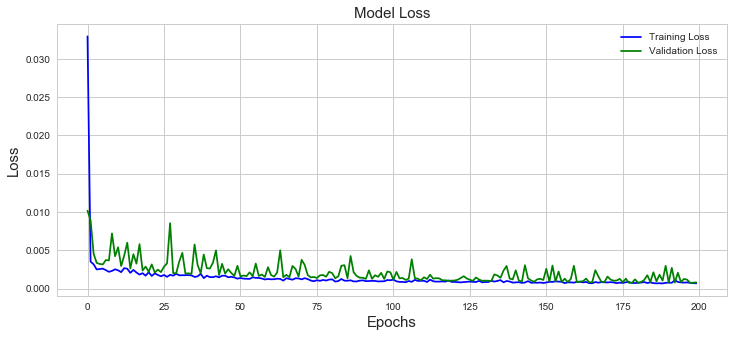

In [83]:
# use to set style of background of plot
sns.set(style ="whitegrid")

# summarize history for loss
plt.figure(figsize = (12,5))
plt.plot(history.history['loss'], color = 'blue', label = 'Training Loss' )
plt.plot(history.history['val_loss'], color = 'green', label = 'Validation Loss')
plt.title('Model Loss', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.legend()
plt.show()

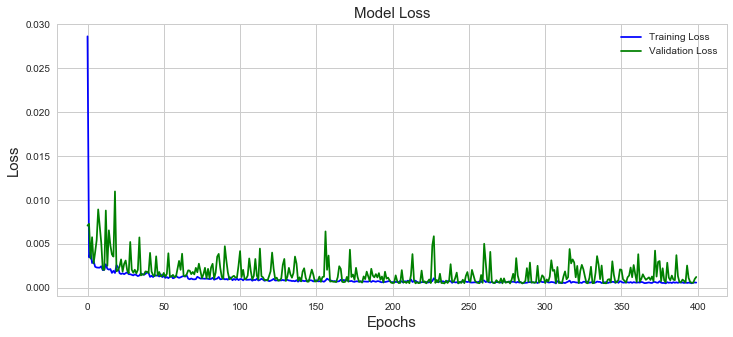

In [21]:
# use to set style of background of plot
sns.set(style ="whitegrid")

# summarize history for loss
plt.figure(figsize = (12,5))
plt.plot(historyX.history['loss'], color = 'blue', label = 'Training Loss' )
plt.plot(historyX.history['val_loss'], color = 'green', label = 'Validation Loss')
plt.title('Model Loss', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.legend()
plt.show()

The more the epochs, the more accurate would be the model. I tried with 200 and 400 epochs.

### Predictions

In [22]:
real_stock_price = test_data.iloc[:,[0,4]].values
real_stock_price = pd.DataFrame(real_stock_price)

In [23]:
real_stock_price.shape

(252, 2)

In [64]:
all_data = pd.concat((train_data['Close'], test_data['Close']), axis = 0)
inputs = all_data[len(all_data) - len(test_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [65]:
inputs.shape

(312, 1)

In [66]:
X_test = []
for i in range(60,test_data.shape[0]+60):
    X_test.append(inputs[i-60:i,0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [67]:
X_test.shape

(252, 60, 1)

In [68]:
best_model = load_model('Stock_Price_model.h5')

predicted_stock_price = best_model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

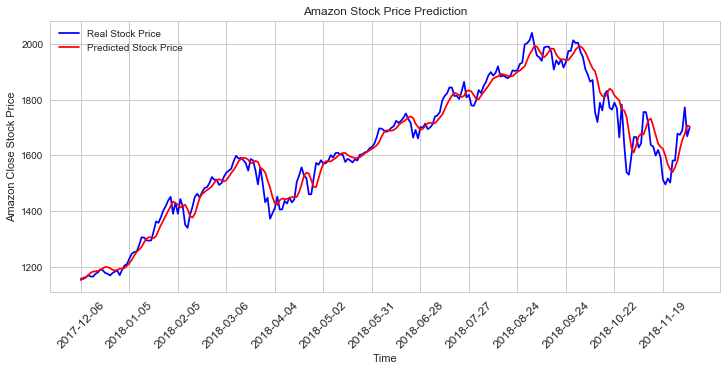

In [69]:
# Visualizing results

sns.set(style ="whitegrid")
plt.figure(figsize = (12,5))
plt.plot(range(real_stock_price.shape[0]),real_stock_price[1],'b',label = 'Real Stock Price')
plt.xticks(range(0,real_stock_price.shape[0],20),real_stock_price[0].loc[::20],rotation=45,fontsize = 12)
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted Stock Price')
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Amazon Close Stock Price')
plt.legend()
plt.show()

In [74]:
print("R2 score of Model I:- ", r2_score(real_stock_price[1], predicted_stock_price))

R2 score of Model I:-  0.9642469564286316


In [71]:
best_modelX = load_model('Stock_Price_ModelX.h5')

predicted_stock_priceX = best_modelX.predict(X_test)
predicted_stock_priceX = sc.inverse_transform(predicted_stock_priceX)

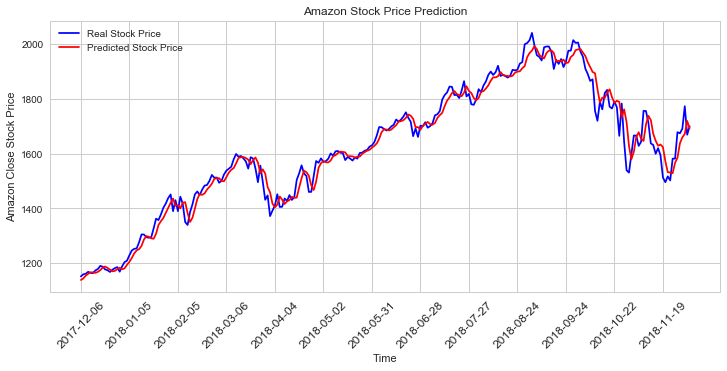

In [72]:
# Visualizing results

sns.set(style ="whitegrid")
plt.figure(figsize = (12,5))
plt.plot(range(real_stock_price.shape[0]),real_stock_price[1],'b',label = 'Real Stock Price')
plt.xticks(range(0,real_stock_price.shape[0],20),real_stock_price[0].loc[::20],rotation=45,fontsize = 12)
plt.plot(predicted_stock_priceX, color = 'red', label = 'Predicted Stock Price')
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Amazon Close Stock Price')
plt.legend()
plt.show()

In [75]:
print("R2 score of Model II:- ", r2_score(real_stock_price[1], predicted_stock_priceX))

R2 score of Model II:-  0.9717018748764154


The R2 score of 2nd model with 400 epochs is more as compared to the model of 200 epochs. the model is better when R2 score is closer to 1. So, for further prediction, I will be considering the 2nd model.

### Predicting for next 30 days

In [113]:
real_stock_price.columns = ['Date', 'Real Stock Price']

In [116]:
predictX_df = pd.DataFrame(predicted_stock_priceX, columns = ['Predicted Stock Price'])

In [215]:
# New dataframe for true stock price and predicted stock price
prediction_df = pd.concat([real_stock_price, predictX_df], axis=1)
prediction_df.head()

,Date,Real Stock Price,Predicted Stock Price
0,2017-12-06,1152.35,1139.236938
1,2017-12-07,1159.79,1144.774536
2,2017-12-08,1162,1154.920532
3,2017-12-11,1168.92,1161.702515
4,2017-12-12,1165.08,1167.043335


Consider the prediction column to further predict future days.

In [174]:
df = prediction_df[['Predicted Stock Price']]

We want to predict 30 days into the future, so we’ll set a variable forecast_out equal to that. Then, we need to create a new column in our dataframe as our output. To fill our output data with data to be trained upon, we will set our  prediction column equal to our Predicted Stock Price column, but shifted 30 units up.

In [176]:
forecast_out = int(30) # predicting 30 days into future
df['Prediction'] = df[['Predicted Stock Price']].shift(-forecast_out)

In [177]:
X = np.array(df.drop(['Prediction'], 1))
X = sc.transform(X)

In [178]:
X_forecast = X[-forecast_out:] # set X_forecast equal to last 30
X = X[:-forecast_out] # remove last 30 from X

In [179]:
y = np.array(df['Prediction'])
y = y[:-forecast_out]

Here, using linear regression I will be predicting the next 30 days.

In [181]:
clf = LinearRegression()
clf.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [182]:
forecast_prediction = clf.predict(X_forecast)
print(forecast_prediction)

[1770.8081 1738.8044 1755.506  1729.779  1680.5001 1653.5728 1668.7498
 1698.8273 1708.6384 1695.7041 1690.8439 1724.5812 1742.1599 1733.7517
 1705.3385 1691.3687 1681.101  1683.6825 1678.2513 1649.2407 1627.0304
 1626.5133 1624.9725 1646.1602 1656.8276 1685.9644 1698.2877 1705.0723
 1731.7654 1716.6438]


In [219]:
last_date = prediction_df.iloc[-1].Date
new_date = pd.date_range(last_date,periods=30,freq='D')

In [234]:
df = pd.concat([pd.DataFrame(new_date), pd.DataFrame(forecast_prediction)], axis=1)
df.columns = ['Date','30 days Stock Price']

In [251]:
df.head()

,Date,30 days Stock Price
0,2018-12-06,1770.808105
1,2018-12-07,1738.804443
2,2018-12-08,1755.505981
3,2018-12-09,1729.779053
4,2018-12-10,1680.500122


In [252]:
new_df = pd.concat([prediction_df, df])

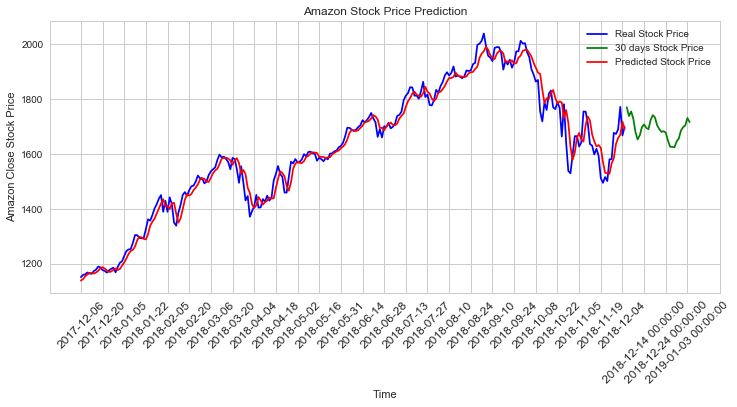

In [258]:
# Visualizing results

sns.set(style ="whitegrid")
plt.figure(figsize = (12,5))
plt.plot(range(real_stock_price.shape[0]),real_stock_price['Real Stock Price'],'b',label = 'Real Stock Price')
plt.plot(range(real_stock_price.shape[0]+30),new_df['30 days Stock Price'],'g')
plt.xticks(range(0,new_df.shape[0],10),new_df['Date'].loc[::10],rotation=45,fontsize = 12)
plt.plot(predicted_stock_priceX, color = 'red', label = 'Predicted Stock Price')
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Amazon Close Stock Price')
plt.legend()
plt.show()